# Heat Equation


## Method 1
Not locally using Flux.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import scipy
import time
import os
from utilities import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Heat:
    def __init__(self, N_x:int, N_t:int, Nint_x:int, deg:int, act: str='tanh') -> None:
        #
        self.name = f'DG_heat_{N_x}_{N_t}_{Nint_x}_{deg}_{act}_legendre'
        self.np_dtype = np.float32
        self.torch_dtype = torch.float32
        #
        self.a = 0.0
        self.b = 1.0
        self.t0 = 0.0
        self.T = 1.0
        #
        self.N_x = N_x
        self.N_t = N_t
        self.Nint_x = Nint_x
        self.deg = deg
        #
        self.testfunc = TestFunction1D(func_type='Polynomial')
        #
        self.x, self.xc, self.h, self.t, self.Mesh, self.xmesh, self.weights = self.get_mesh()
        self.v, self.dv = self.test_data()
        self.model = DGNet(num_modules=self.N_x, input_size=2, hidden_size=50, output_size=1, num_layers=2, act=act).to(device)
        #
        self.f = lambda x, t: pi * torch.sin(pi * x) * (pi * torch.cos(pi * t) - torch.sin(pi * t))
        self.init = lambda x: torch.sin(pi * x)
        self.flux = lambda x, y: x - y
        self.exact = lambda x, t: torch.cos(pi * t) * torch.sin(pi * x)
        #
        self.exact_init = self.init(self.xmesh)
        self.exact_sol = self.exact(self.Mesh[..., 0], self.Mesh[..., 1])
        self.fxt = self.f(self.Mesh[:, :, 1:-1, 0], self.Mesh[:, :, 1: -1, 1])
        #
        self.Lfbgs = torch.optim.LBFGS(self.model.parameters(), lr=1.0, max_iter=50000, 
                                           max_eval=50000, history_size=50, tolerance_grad=1e-7, 
                                           tolerance_change=1.0 * np.finfo(float).eps, 
                                           line_search_fn='strong_wolfe')
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-4); self.maxiter = 5000; self.adamiter = 0
        self.iter = 0
    
    def pre_data(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux = gradu[..., 0]; ut = gradu[..., 1]
        #
        lux = ux[:, :, 0]; rux = ux[:, :, -1]
        lv = self.v[:, :, 0]; rv = self.v[:, :, -1]
        bd = rux[None, ...] * rv[:, :, None] - lux[None, ...] * lv[:, :, None]
        #
        flux_u = self.flux(u[:-1, :, -1, 0], u[1:, :, 0, 0])
        flux_ux = self.flux(ux[:-1, :, -1], ux[1:, :, 0])   
        return u, ut, ux, gradu, flux_u, flux_ux, bd   

    def test_data(self):
        v_list = []
        dv_list = []
        for i in range(self.deg + 1):
            v, dv = self.testfunc.get_value(x=self.xmesh, x_mid=self.xc[:, None], h=self.h[:, None], order=i)
            v_list.append(v)
            dv_list.append(dv)
        v = torch.stack(v_list, dim=0).to(device)
        dv = torch.stack(dv_list, dim=0).to(device)
        return v, dv
    
    def get_mesh(self):
        #
        x = np.linspace(self.a, self.b, self.N_x + 1)
        t = np.linspace(self.t0, self.T, self.N_t + 1)
        xc = (x[:-1] + x[1:]) / 2.0
        h = (x[1:] - x[:-1]) 
        nodes, weights = np.polynomial.legendre.leggauss(self.Nint_x)
        #
        mesh = 0.5 * (nodes[None, :] + 1) * h[:, None] + x[:-1, None]
        weights = 0.5 * weights[None, :] * h[:, None]
        xmesh = np.zeros((self.N_x, self.Nint_x + 2))
        xmesh[:, 1:-1] = mesh
        xmesh[:, 0] = x[:-1]
        xmesh[:, -1] = x[1:]
        Mesh = []
        for i in range(self.N_x):
            xx, tt = np.meshgrid(xmesh[i, :], t)
            Mesh.append(np.stack([xx, tt], axis=-1))
        Mesh = np.array(Mesh)
        return torch.tensor(x, dtype=self.torch_dtype).to(device), \
               torch.tensor(xc, dtype=self.torch_dtype).to(device), \
               torch.tensor(h, dtype=self.torch_dtype).to(device),\
               torch.tensor(t, dtype=self.torch_dtype).to(device),\
               torch.tensor(Mesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(xmesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(weights, dtype=self.torch_dtype).to(device)

    def exact_loss(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.exact_sol
        ux = pi * torch.cos(pi * Mesh[..., 1]) * torch.cos(pi * Mesh[..., 0])
        ut = -pi * torch.sin(pi * Mesh[..., 1]) * torch.sin(pi * Mesh[..., 0])
        lux = ux[:, :, 0]; rux = ux[:, :, -1]
        lv = self.v[:, :, 0]; rv = self.v[:, :, -1]
        bd = rux[None, ...] * rv[:, :, None] - lux[None, ...] * lv[:, :, None]
        #
        flux_u = self.flux(u[:-1, :, -1], u[1:, :, 0])
        flux_ux = self.flux(ux[:-1, :, -1], ux[1:, :, 0]) 
        ux = ux[:, :, 1:-1]; ut = ut[:, :, 1:-1]  
        # compute local loss
        Int = torch.sum(((ut[None, ...] - self.fxt[None, ...]) * self.v[:, :, None, 1:-1] + ux[None, ...] * self.dv[:, :, None, 1:-1]) * self.weights[None, :, None, :], dim=-1) - bd # [deg + 1, N_x, N_t + 1]
        local_loss = torch.sum(Int**2)
        # compute init_loss
        init_loss = torch.sum((u[:, 0, :] - self.exact_init)**2)
        # compute bd_loss
        bd_loss = torch.sum(u[0, :, 0]**2 + u[-1, :, -1]**2)
        # compute flux_loss
        flux_loss = torch.sum(flux_u**2 + flux_ux**2)
        loss = local_loss + init_loss + bd_loss + flux_loss
        return loss
    
    def loss(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux = gradu[..., 0]; ut = gradu[..., 1]
        #
        lux = ux[:, :, 0]; rux = ux[:, :, -1]
        lv = self.v[:, :, 0]; rv = self.v[:, :, -1]
        bd = rux[None, ...] * rv[:, :, None] - lux[None, ...] * lv[:, :, None]
        #
        flux_u = self.flux(u[:-1, :, -1, 0], u[1:, :, 0, 0])
        flux_ux = self.flux(ux[:-1, :, -1], ux[1:, :, 0]) 
        ux = ux[:, :, 1:-1]; ut = ut[:, :, 1:-1]

        # compute local loss
        Int = torch.sum(((ut[None, ...] - self.fxt[None, ...]) * self.v[:, :, None, 1:-1] + ux[None, ...] * self.dv[:, :, None, 1:-1]) * self.weights[None, :, None, :], dim=-1) - bd # [deg + 1, N_x, N_t + 1]
        local_loss = torch.sum(Int**2)
        # compute init_loss
        init_loss = torch.sum((u[:, 0, :, 0] - self.exact_init)**2)
        # compute bd_loss
        bd_loss = torch.sum(u[0, :, 0, 0]**2 + u[-1, :, -1, 0]**2)
        # compute flux_loss
        flux_loss = torch.sum(flux_u**2 + flux_ux**2)
        loss = local_loss + init_loss + bd_loss + flux_loss
        return loss
    
    def loss_lfbgs(self):
        self.Lfbgs.zero_grad()
        loss = self.loss()
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(f"LBFGS At iter: {self.iter}, loss_train:{loss.item():.6f}")
        return loss
    
    def loss_adam(self):
        self.Adam.zero_grad()
        loss = self.loss()
        self.adamiter += 1
        if self.adamiter % 100 == 0:
            print(f"Adam At iter: {self.adamiter}, loss_train:{loss.item():.6f}")
        return loss
    def train(self):
        t_start = time.time()
        print('*********** Started training ...... ***************')
        self.Lfbgs.step(self.loss_lfbgs)
        torch.save(self.model.state_dict(), f'./models/{self.name}.pth')
        loss = self.loss_adam()
        best_loss = loss
        while loss > 1e-5:
            loss.backward()
            self.Adam.step()
            loss = self.loss_adam()
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), f'./models/{self.name}.pth')
            if self.adamiter > self.maxiter:
                break
        self.adamiter = 0
        print(f'Finished training in {time.time()-t_start:.4f} seconds')
    def load(self):
        path = f'./models/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Training the model...")
            return False
H = Heat(N_x=15, N_t=10, Nint_x=20, deg=3)
print(H.exact_loss())
print(H.loss())
# while H.loss() > 1e-5:
#     H.train()

tensor(1.0457e-09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(60858.5469, device='cuda:0', grad_fn=<AddBackward0>)


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


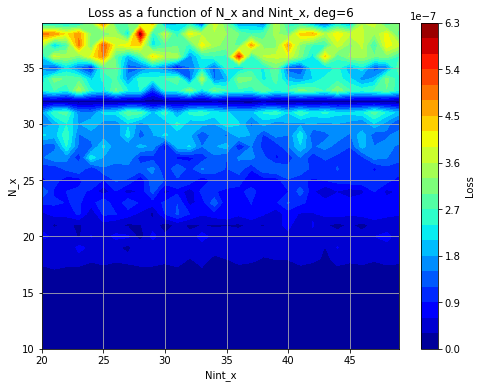

In [25]:
def plot_loss_vs_Nx_Nint():
    N_x_values = range(10, 40, 1)  # 设置N_x的取值范围
    Nint_values = range(20, 50, 1)  # 设置Nint_x的取值范围
    losses = np.zeros((len(N_x_values), len(Nint_values)))  # 用于存储每对(N_x, Nint_x)的loss值
    deg = 6; N_t = 20
    # 计算每一组 N_x 和 Nint_x 对应的loss
    for i, N_x in enumerate(N_x_values):
        for j, Nint_x in enumerate(Nint_values):
            p = Heat(N_x=N_x, N_t=N_t, Nint_x=Nint_x, deg=deg)  
            loss = p.exact_loss() 
            loss = loss.cpu().detach().numpy()  # 如果loss是tensor，转为numpy
            losses[i, j] = loss  # 存储到对应的位置
            del p

    # 绘制loss关于N_x和Nint_x的图
    X, Y = np.meshgrid(Nint_values, N_x_values)  # 创建网格
    fig = plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, losses, levels=20, cmap='jet')  # 使用contourf绘制填充轮廓图
    fig.colorbar(cp, label='Loss')  # 添加颜色条
    plt.xlabel('Nint_x')
    plt.ylabel('N_x')
    plt.title(f'Loss as a function of N_x and Nint_x, deg={deg}')
    plt.grid(True)
    plt.show()

# 调用函数绘图
plot_loss_vs_Nx_Nint()

In [32]:
H = Heat(N_x=15, N_t=10, Nint_x=20, deg=3)
if not H.load():
    while H.loss() > 1e-5:
        H.train()

No saved model found. Training the model...
*********** Started training ...... ***************


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


LBFGS At iter: 100, loss_train:3.606318
LBFGS At iter: 200, loss_train:0.910936
LBFGS At iter: 300, loss_train:0.340676
LBFGS At iter: 400, loss_train:0.160807
LBFGS At iter: 500, loss_train:0.097811
LBFGS At iter: 600, loss_train:0.067244
LBFGS At iter: 700, loss_train:0.046179
LBFGS At iter: 800, loss_train:0.032194
LBFGS At iter: 900, loss_train:0.023404
LBFGS At iter: 1000, loss_train:0.017551
LBFGS At iter: 1100, loss_train:0.013845
LBFGS At iter: 1200, loss_train:0.010831
LBFGS At iter: 1300, loss_train:0.008932
LBFGS At iter: 1400, loss_train:0.007544
LBFGS At iter: 1500, loss_train:0.006486
LBFGS At iter: 1600, loss_train:0.005667
LBFGS At iter: 1700, loss_train:0.005060
LBFGS At iter: 1800, loss_train:0.004527
LBFGS At iter: 1900, loss_train:0.004004
LBFGS At iter: 2000, loss_train:0.003561
LBFGS At iter: 2100, loss_train:0.003161
LBFGS At iter: 2200, loss_train:0.002855
LBFGS At iter: 2300, loss_train:0.002622
LBFGS At iter: 2400, loss_train:0.002427
LBFGS At iter: 2500, loss

KeyboardInterrupt: 

/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


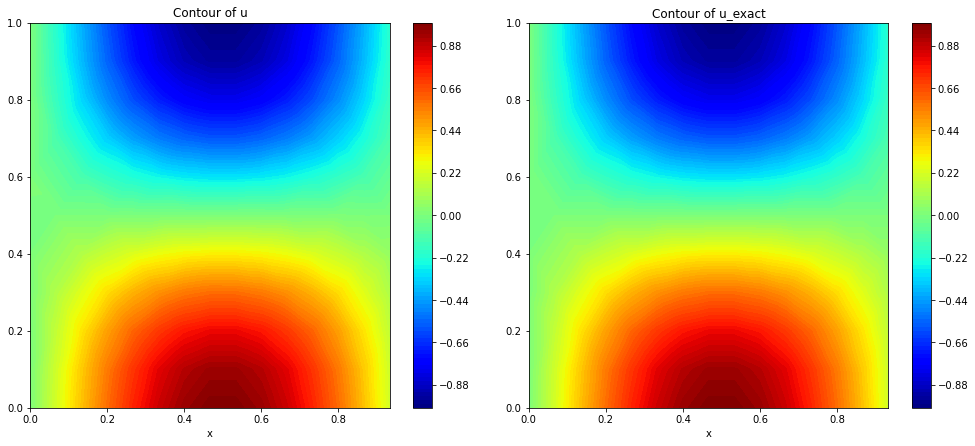

In [34]:
xt = H.Mesh[:, :, ::100, :]
u = H.model(xt).squeeze(-1)
u_exact = H.exact_sol[:, :, ::100]
error = abs(u-u_exact)

xt = xt.detach().cpu().numpy().reshape(-1, 2)
u = u.detach().cpu().numpy().flatten()
u_exact = u_exact.detach().cpu().numpy().flatten()
error = error.detach().cpu().numpy().flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 绘制第一个图：u 的轮廓图
pic = ax1.tricontourf(xt[:, 0], xt[:, 1], u, levels=100, cmap='jet')
fig.colorbar(pic, ax=ax1)
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_title('Contour of u')

# 绘制第二个图：u_exact 的轮廓图
pic_exact = ax2.tricontourf(xt[:, 0], xt[:, 1], u_exact, levels=100, cmap='jet')
fig.colorbar(pic_exact, ax=ax2)
ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_title('Contour of u_exact')

plt.tight_layout()
plt.show()


Text(0.5, 0, 'x')

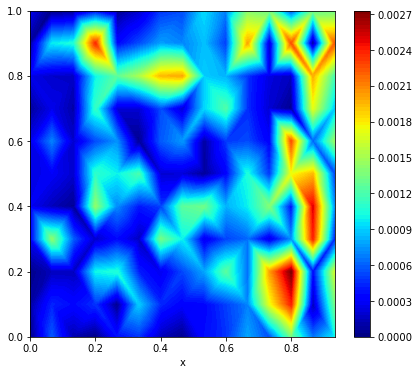

In [36]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
pic = ax.tricontourf(xt[:,0], xt[:,1], error, levels=100, cmap='jet')
fig.colorbar(pic, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel('x')